In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_built_with_cuda()

True

In [21]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 5
import os
# Define the path to the directory containing image data
data_directory = "../PlantVillage"

data_directory = os.path.abspath(data_directory)


In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(data_directory, shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE)
                                                   ,batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape, label_batch.numpy())
    print(image_batch[0].numpy())

(32, 256, 256, 3) [0 1 1 0 0 0 0 1 2 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1]
[[[134. 133. 141.]
  [143. 142. 150.]
  [174. 173. 181.]
  ...
  [190. 193. 202.]
  [187. 190. 199.]
  [184. 187. 196.]]

 [[141. 140. 148.]
  [133. 132. 140.]
  [170. 169. 177.]
  ...
  [190. 193. 202.]
  [187. 190. 199.]
  [185. 188. 197.]]

 [[172. 171. 179.]
  [157. 156. 164.]
  [150. 149. 157.]
  ...
  [190. 193. 202.]
  [187. 190. 199.]
  [185. 188. 197.]]

 ...

 [[153. 155. 167.]
  [163. 165. 177.]
  [149. 151. 163.]
  ...
  [166. 168. 181.]
  [165. 167. 180.]
  [165. 167. 180.]]

 [[147. 149. 162.]
  [162. 164. 177.]
  [149. 151. 163.]
  ...
  [165. 167. 180.]
  [164. 166. 179.]
  [164. 166. 179.]]

 [[142. 144. 157.]
  [161. 163. 176.]
  [129. 131. 143.]
  ...
  [163. 165. 178.]
  [168. 170. 183.]
  [171. 173. 186.]]]


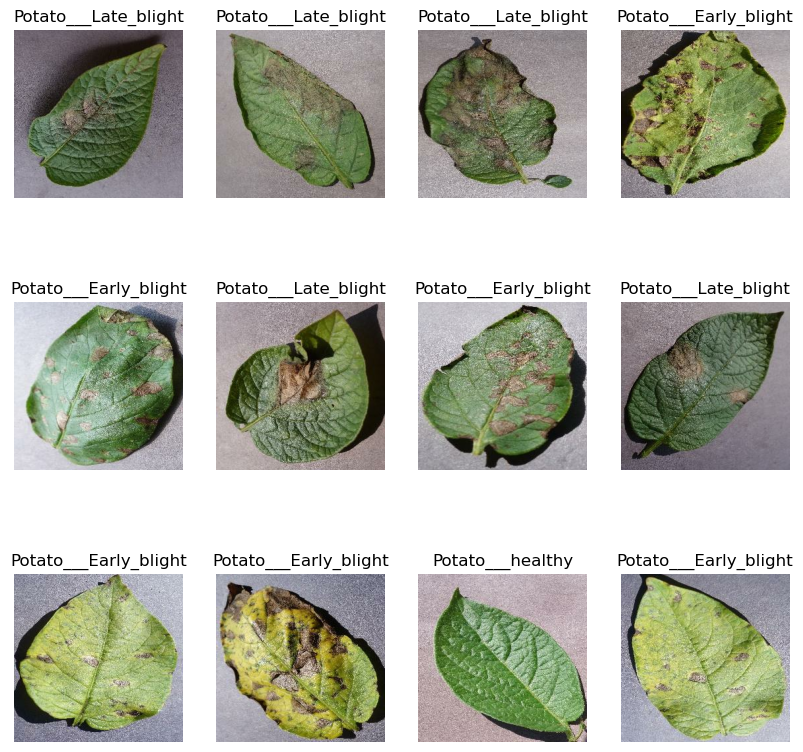

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('OFF')
        plt.title(class_names[label_batch[i].numpy()])

In [10]:
def get_dataset_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    if(shuffle):
        ds.shuffle(shuffle_size, seed=5)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
                                        
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_split(dataset)

In [12]:
len(test_ds)

8

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
n_classes = 3
model = keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    #dense
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')

])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [18]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [31]:
history = model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/5
54/54 [==============================] - 51s 893ms/step - loss: 0.1491 - accuracy: 0.9416 - val_loss: 0.2494 - val_accuracy: 0.9115
Epoch 2/5
54/54 [==============================] - 55s 866ms/step - loss: 0.1335 - accuracy: 0.9456 - val_loss: 0.1795 - val_accuracy: 0.9271
Epoch 3/5
54/54 [==============================] - 50s 862ms/step - loss: 0.1247 - accuracy: 0.9502 - val_loss: 0.1610 - val_accuracy: 0.9375
Epoch 4/5
54/54 [==============================] - 43s 723ms/step - loss: 0.1245 - accuracy: 0.9525 - val_loss: 0.1437 - val_accuracy: 0.9688
Epoch 5/5
54/54 [==============================] - 42s 692ms/step - loss: 0.1075 - accuracy: 0.9595 - val_loss: 0.1427 - val_accuracy: 0.9479


In [32]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 29ms/step - loss: 0.1225 - accuracy: 0.9612


In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
print(val_loss)

[0.2493566870689392, 0.17954528331756592, 0.1609870344400406, 0.14374147355556488, 0.1427038311958313]


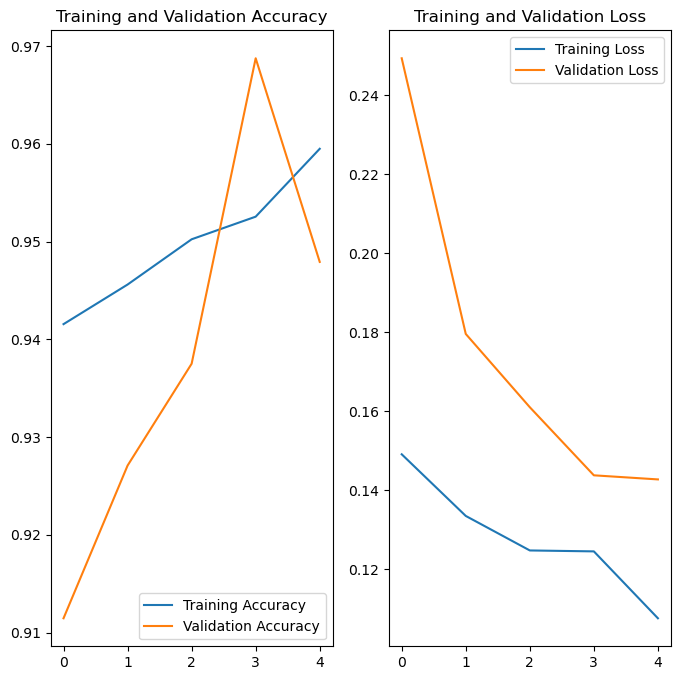

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


image to predict:
first image actual label: Potato___Early_blight
1/1 [==============================] - 7s 7s/step
model predicted: Potato___Early_blight


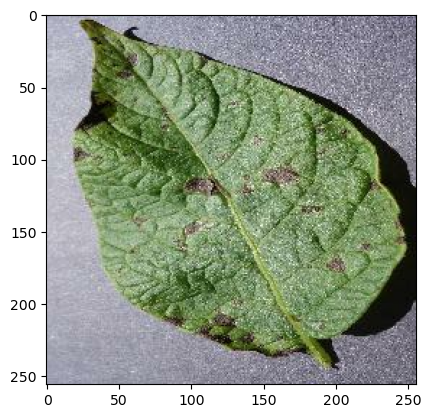

In [36]:
import numpy as np
for image_batch, lablel_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_image_label = lablel_batch[0].numpy()
    
    print("image to predict:")
    plt.imshow(first_image)
    print(f'first image actual label: {class_names[first_image_label]}')
    
    batch_predicted = model.predict(image_batch)
    print(f'model predicted: {class_names[np.argmax(batch_predicted[0])]}')

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 2s 2s/step


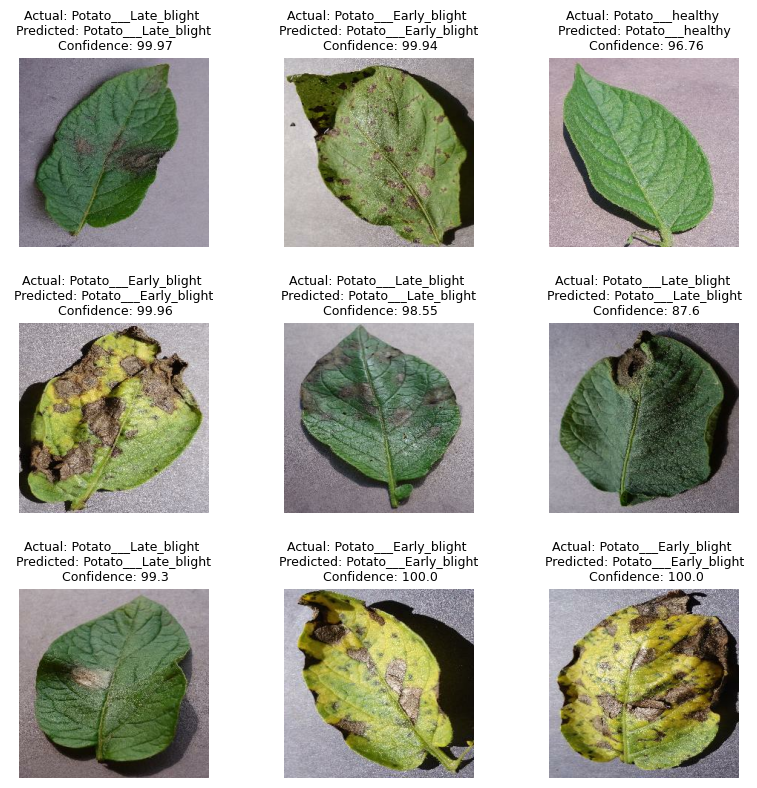

In [38]:
plt.figure(figsize=(9,9))
for image_batch, lablel_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        actual_class = class_names[lablel_batch[i].numpy()]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}", fontsize=9)
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

        plt.axis('off')

In [39]:
import os
next_model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{next_model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
